<a href="https://colab.research.google.com/github/aatiqa-ghazali/covid/blob/main/fullModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [5]:
# Define constants
SEED = 1
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir_train = '/content/drive/MyDrive/newdata/slices'
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'data')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'label')



NUM_TRAIN = 120


NUM_OF_EPOCHS = 100

In [6]:
#take the images from all directories and feed them to the neural netwrok
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [7]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)


Found 43133 images belonging to 1 classes.
Found 33148 images belonging to 1 classes.


In [8]:
def display(display_list):
    plt.figure(figsize=(30,30))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [9]:

def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

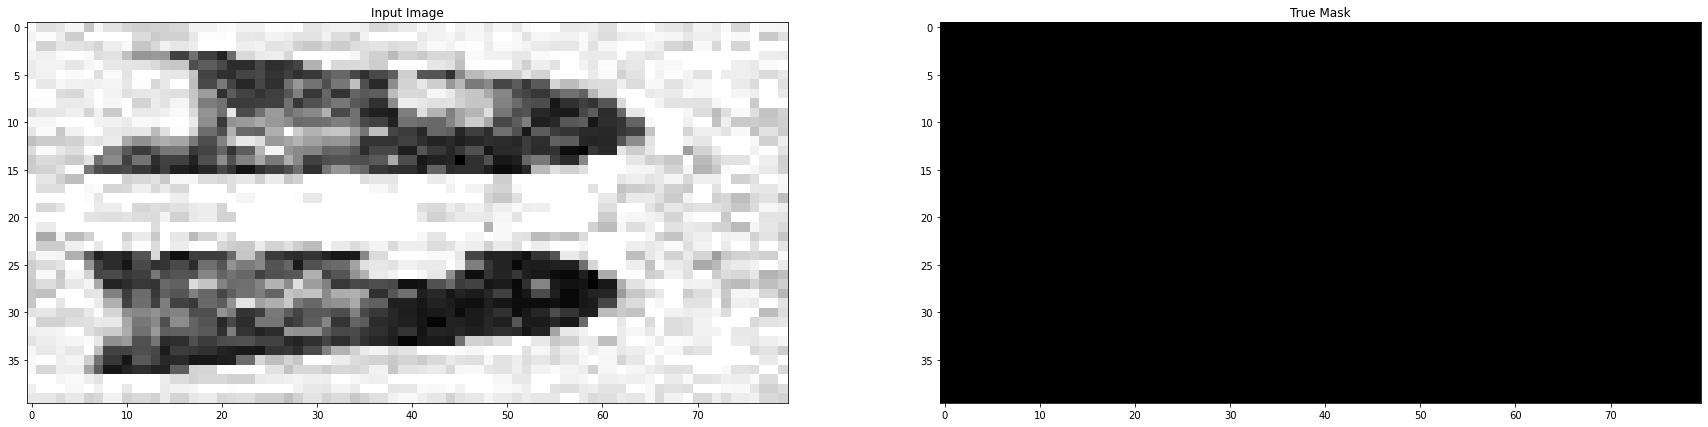

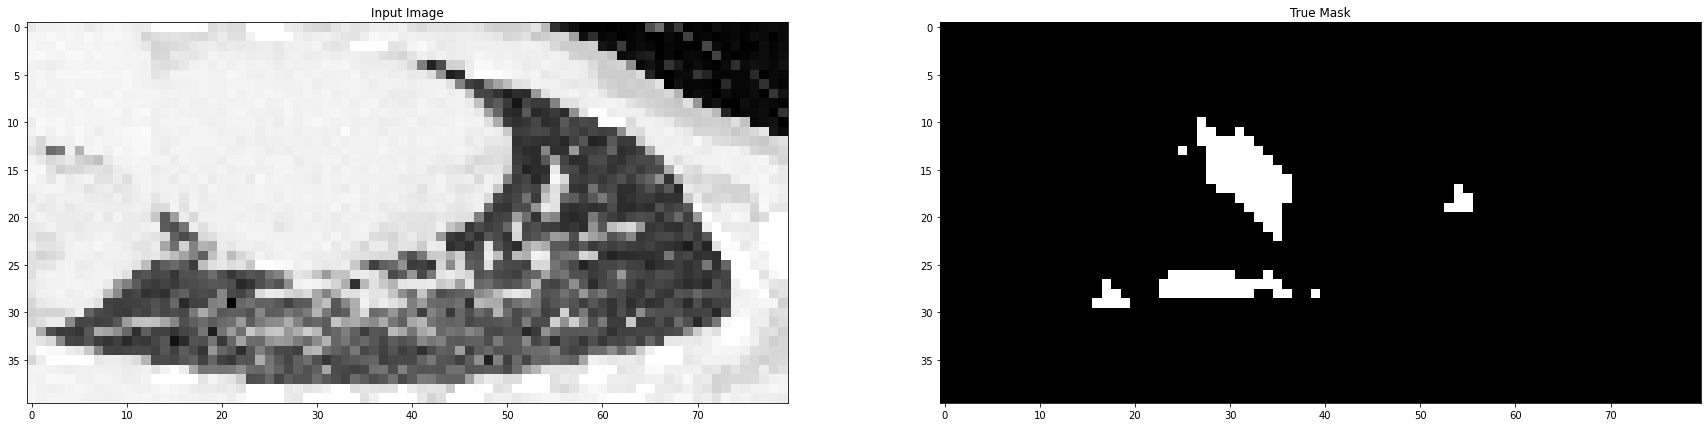

In [10]:
show_dataset(train_generator, 2)


In [11]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [12]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()


Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 80, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 20, 40, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [15]:
history=model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                   epochs=NUM_OF_EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
3/3 [==============================] - 42s 19s/step - loss: 0.6644 - accuracy: 0.6708
Epoch 2/100
3/3 [==============================] - 57s 19s/step - loss: 0.4796 - accuracy: 0.9855
Epoch 3/100
3/3 [==============================] - 57s 19s/step - loss: 0.1568 - accuracy: 0.9889
Epoch 4/100
3/3 [==============================] - 58s 19s/step - loss: 0.1116 - accuracy: 0.9876
Epoch 5/100
3/3 [==============================] - 57s 19s/step - loss: 0.1070 - accuracy: 0.9826
Epoch 6/100
3/3 [==============================] - 56s 19s/step - loss: 0.1261 - accuracy: 0.9790
Epoch 7/100
3/3 [==============================] - 57s 19s/step - loss: 0.0793 - accuracy: 0.9883
Epoch 8/100
3/3 [==============================] - 55s 18s/step - loss: 0.0630 - accuracy: 0.9897
Epoch 9/100
3/3 [==============================] - 56s 19s/step - loss: 0.0865 - accuracy: 0.9874
Epoch 10/100
3/3 [==============================] - 57s 19s/step - loss: 0.0998 - accuracy: 0.9828
Epoch 11/100
3/3 [=

In [16]:
# list all data in history
print(history.history.keys())


dict_keys(['loss', 'accuracy'])


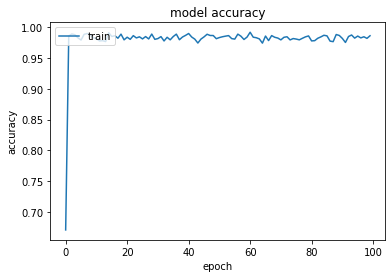

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


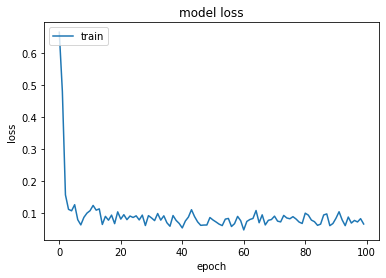

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
model.save(f'unet2D_results_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/UNET-ToothSegmentation_40_80.h5')

In [ ]:
import tensorflow.keras as keras


In [ ]:
model.evaluate()

ValueError: ignored

In [ ]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)


NameError: ignored

In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

In [ ]:
show_prediction(test_generator, 3)


NameError: ignored